# Final Report of Team 11, Instant Recipes from Food Images

### Team Members: Biqi Wu, Kuang Ren, Yaoyang Zhang, Zhijing Ouyang


Our project is focused on developing a system that automatically generates recipes and extracts ingredient lists from food images. To achieve this, we employ a multi-agent approach for food analysis, organized into three main modules:
1. **Localization Module**  
   - Detects and locates food items within images.

2. **Classification Module**  
   - Identifies the specific dishes based on the positions determined by the localization module.

3. **Language Module**  
   - Generates detailed recipes and cooking instructions by combining the recognition results with prompt-engineered large language models (e.g., DeepSeek) and our proprietary database.


## Model 1: Fine-tuned YOLOv11-based Food Detection and Localization Model

We built our food detection system using **YOLOv11**, an advanced real-time object detection model developed by [Ultralytics](https://docs.ultralytics.com/models/yolo11/). To specialize it for meal recognition, we retrained the model on the [UECFood256](http://foodcam.mobi/dataset256.html) dataset containing 256 types of dishes. Instead of detecting general objects like regular YOLO does, we modified the system to only look for complete meals and food containers. The dataset came ready with food location markers, which we converted into the format YOLOv11 needs for training - this included adjusting the coordinate system and simplifying the labels. All this data preparation work is already completed, so our code skips those steps now that everything's properly formatted for the model.

In [ ]:
import os
import pandas as pd
import shutil
import numpy as np
import kagglehub
from PIL import Image
from ultralytics import YOLO
import cv2

path = kagglehub.dataset_download("rkuo2000/uecfood256")

### Data Splitting

In [ ]:
original_path = "dataset/UECFOOD256"
process_path = "dataset/PROCESSED_UECFOOD256"

# Create main output directory
os.makedirs(process_path, exist_ok=True)

def read_bb_info(info_path):
    new_df = pd.read_csv(
        info_path,
        sep='\s+',
        names=['img', 'x1', 'y1', 'x2', 'y2'],
        skiprows=1
    )
    return new_df

info_df = pd.DataFrame(columns=['img', 'x1', 'y1', 'x2', 'y2', 'split'])

for i in range(1, 257):
    cur_original_folder = os.path.join(original_path, str(i))

    # Skip if folder doesn't exist
    if not os.path.isdir(cur_original_folder):
        print(f"Skipping invalid directory: {cur_original_folder}")
        continue

    # Get all JPG files
    jpg_files = [f for f in os.listdir(cur_original_folder)
                 if f.lower().endswith('.jpg')]

    # Skip if no images
    if not jpg_files:
        print(f"No JPGs in {cur_original_folder}")
        continue

    # Split into train/val/test (70-15-15)
    np.random.seed(1005707059)
    np.random.shuffle(jpg_files)
    n_total = len(jpg_files)
    train_files = jpg_files[:int(0.7 * n_total)]
    val_files = jpg_files[int(0.7 * n_total):int(0.85 * n_total)]
    test_files = jpg_files[int(0.85 * n_total):]

    # Process bounding box info
    cur_info_path = os.path.join(cur_original_folder, 'bb_info.txt')
    if os.path.exists(cur_info_path):
        temp_df = read_bb_info(cur_info_path)

        # Add folder prefix to create unique IDs
        temp_df['img'] = temp_df['img'].apply(lambda x: f"{i}_{x}")

        # Generate split IDs with folder prefix
        val_img_ids = [f"{i}_{os.path.splitext(f)[0]}" for f in val_files]
        test_img_ids = [f"{i}_{os.path.splitext(f)[0]}" for f in test_files]

        temp_df['split'] = 'train'
        temp_df.loc[temp_df['img'].isin(val_img_ids), 'split'] = 'valid'
        temp_df.loc[temp_df['img'].isin(test_img_ids), 'split'] = 'test'

        info_df = pd.concat([info_df, temp_df], ignore_index=True)
    else:
        print(f"Warning: {cur_info_path} not found")

    # Copy images with unique names
    for split_name, files in zip(['train', 'valid', 'test'], [train_files, val_files, test_files]):
        split_folder = os.path.join(process_path, split_name)
        image_folder = os.path.join(split_folder, "images")
        os.makedirs(image_folder, exist_ok=True)

        for img_file in files:
            src = os.path.join(cur_original_folder, img_file)
            new_name = f"{i}_{img_file}"  # Changed here - add folder prefix
            dst = os.path.join(image_folder, new_name)
            shutil.copy2(src, dst)

# Add unified label column
info_df['label'] = 0

# Save split-specific bounding box info
for split in ['train', 'valid', 'test']:
    split_df = info_df[info_df['split'] == split]
    split_path = os.path.join(process_path, split, 'bb_info.txt')

    split_df.to_csv(
        split_path,
        sep=' ',
        index=False,
        columns=['img', 'x1', 'y1', 'x2', 'y2', 'label']
    )
    print(f"Saved {len(split_df)} entries to {split_path}")

print("Processing complete!")

Saved 22021 entries to dataset/PROCESSED_UECFOOD256\train\bb_info.txt
Saved 4760 entries to dataset/PROCESSED_UECFOOD256\valid\bb_info.txt
Saved 4864 entries to dataset/PROCESSED_UECFOOD256\test\bb_info.txt
Processing complete!


### Data Labelling

In [ ]:
data_dir = "dataset/PROCESSED_UECFOOD256"
set_list = ["test", "train", "valid"]
info_file_name = "bb_info.txt"


def process_info(current_dir, img_id, x1, y1, x2, y2):
    """Convert bounding box coordinates to YOLO format"""
    img_folder = os.path.join(current_dir, "images")
    img_path = os.path.join(img_folder, f"{img_id}.jpg")

    try:
        with Image.open(img_path) as img:
            img_width, img_height = img.size
    except FileNotFoundError:
        raise FileNotFoundError(f"Image {img_path} not found")

    # Calculate normalized coordinates
    cx = (x1 + x2) / (2 * img_width)
    cy = (y1 + y2) / (2 * img_height)
    w = (x2 - x1) / img_width
    h = (y2 - y1) / img_height

    return cx, cy, w, h


for set_name in set_list:
    set_dir = os.path.join(data_dir, set_name)
    labels_dir = os.path.join(set_dir, "labels")

    # Create labels directory if not exists
    os.makedirs(labels_dir, exist_ok=True)

    # Read bounding box info
    info_path = os.path.join(set_dir, info_file_name)
    info_df = pd.read_csv(
        info_path,
        sep='\s+',
        names=['img', 'x1', 'y1', 'x2', 'y2', 'label']
    )

    # Process each bounding box
    for _, row in info_df.iterrows():
        if row['img'] != "img":
            try:
                cx, cy, w, h = process_info(
                    set_dir,
                    row['img'],
                    int(row['x1']),
                    int(row['y1']),
                    int(row['x2']),
                    int(row['y2'])
                )

                # Write to annotation file
                ann_path = os.path.join(labels_dir, f"{row['img']}.txt")
                with open(ann_path, 'a') as f:  # Append mode for multiple objects
                    f.write(f"{int(row['label'])} {cx} {cy} {w} {h}\n")

            except FileNotFoundError as e:
                print(f"Skipping: {e}")
                continue

print("YOLO annotation files created successfully!")

YOLO annotation files created successfully!


### Training

The code and yaml of training process is shown below:

In [ ]:
# model = YOLO("yolo11n.pt")
#
# # tune the yolo model
# model.train(data="uecfood256.yaml", epochs=200, imgsz=512, name="yolov11_food")

The result of training is stored to best_model1.pt

In [ ]:
model_1 = YOLO("best_model1.pt")

### Sample result (Original Label):

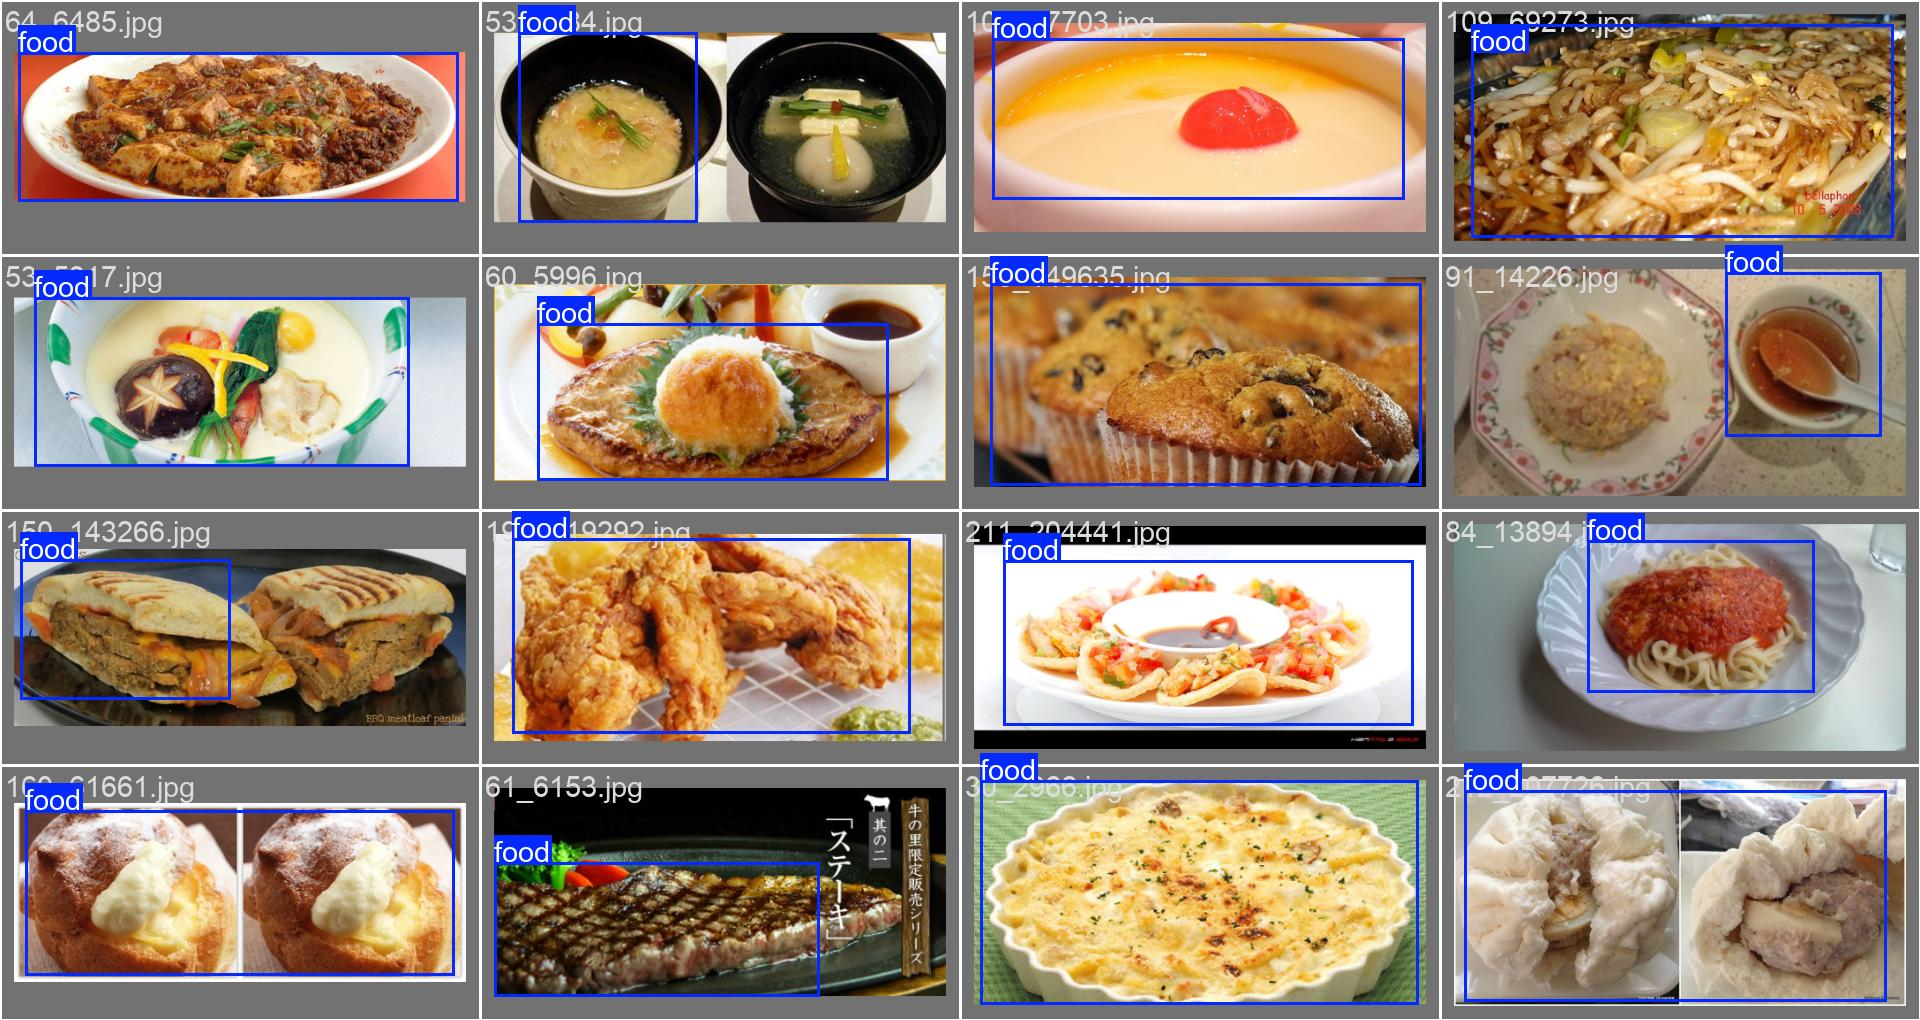

### Sample result (Prediction Label):


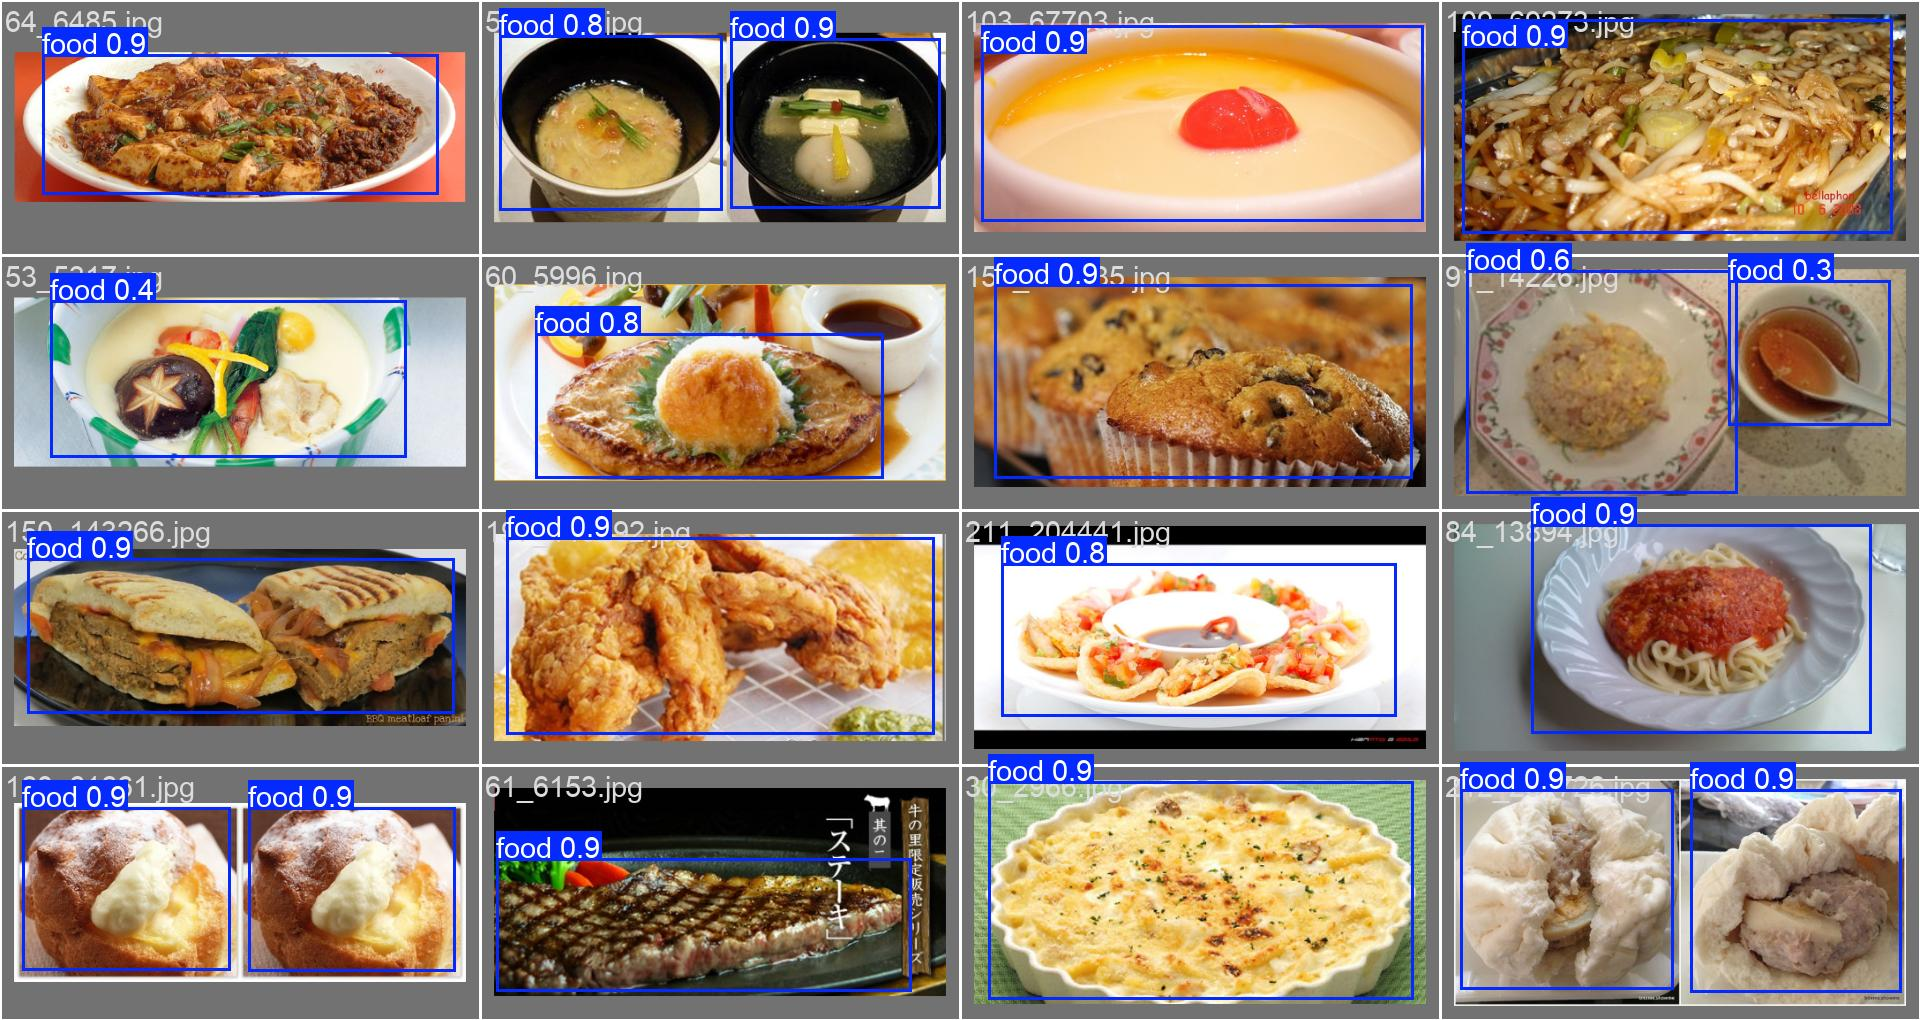

### Calling Model 1

In [ ]:
def yolo_predict(model, img):
    """Single-class prediction with box filtering"""
    results = model.predict(img, imgsz=512)

    # Extract predictions
    boxes = results[0].boxes.xyxy.cpu().numpy()
    if len(boxes) == 0:
        return img, [], [], []

    scores = results[0].boxes.conf.cpu().numpy()

    # Sort by area (descending)
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    sort_idx = np.argsort(areas)[::-1]

    sorted_boxes = boxes[sort_idx]
    sorted_scores = scores[sort_idx]

    # Filter containing boxes
    keep = []
    suppressed = set()

    for i in range(len(sorted_boxes)):
        if i in suppressed:
            continue
        keep.append(i)
        for j in range(i + 1, len(sorted_boxes)):
            if j in suppressed:
                continue
            xi1, yi1, xi2, yi2 = sorted_boxes[i]
            xj1, yj1, xj2, yj2 = sorted_boxes[j]

            if (xj1 >= xi1) and (yj1 >= yi1) and (xj2 <= xi2) and (yj2 <= yi2):
                suppressed.add(i)
                break

    # Apply filtering
    final_idx = [idx for idx in keep if idx not in suppressed]
    filtered_boxes = sorted_boxes[final_idx]
    filtered_scores = sorted_scores[final_idx]

    # Create annotated image
    output_img = img.copy()
    for box in filtered_boxes:
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(output_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Crop detected foods
    cropped_images = [img[y1:y2, x1:x2] for x1, y1, x2, y2 in filtered_boxes.astype(int)]

    return output_img, cropped_images, filtered_boxes, filtered_scores

def get_yolo_result(model, image, output_dir=None):
    """Simplified single-class result handler"""
    annotated_img, cropped_images, boxes, scores = yolo_predict(model, image)

    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)
        cv2.imwrite(os.path.join(output_dir, f"annotated.jpg"), annotated_img)

        for i, crop in enumerate(cropped_images):
            cv2.imwrite(os.path.join(output_dir, f"food_{i + 1}.jpg"), crop)

    return {
        'annotated_image': annotated_img,
        'food_images': cropped_images,
        'boxes': boxes,
        'scores': scores
    }

## Model 2: ResNet50-based Food Classification Model

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("rkuo2000/uecfood256")

# print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/rkuo2000/uecfood256/versions/1


In [ ]:
import os

data_dir = r"C:/Users/zhang/Desktop/UECFOOD256"
items = os.listdir(data_dir)[:10]

In [ ]:
import pandas as pd

# Read category.txt
category_file = "C:/Users/zhang/Desktop/UECFOOD256/category.txt"

# Read with pandas and remove the header row
df = pd.read_csv(category_file, sep="\t", header=0)

# Convert to dictionary {id: name}
id_to_label = dict(zip(df["id"], df["name"]))

# Print first 10 mappings
print("Category Mapping (First 10):")
for k, v in list(id_to_label.items())[:10]:
    print(f"{k}: {v}")


Category Mapping (First 10):
1: rice
2: eels on rice
3: pilaf
4: chicken-'n'-egg on rice
5: pork cutlet on rice
6: beef curry
7: sushi
8: chicken rice
9: fried rice
10: tempura bowl


In [ ]:
import os
import shutil
import random

# Define paths
data_dir = "C:/Users/zhang/Desktop/UECFOOD256"
output_dir = "C:/Users/zhang/Desktop/UECFOOD256_split"

# Define train/val/test split
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create output directories
for split in ["train", "val", "test"]:
    os.makedirs(f"{output_dir}/{split}", exist_ok=True)

# Process each category folder (1, 2, ..., 256)
category_folders = [f for f in os.listdir(data_dir) if f.isdigit()]
category_folders.sort(key=int)  # Sort numerically

for category in category_folders:
    img_folder = os.path.join(data_dir, category)
    images = [f for f in os.listdir(img_folder) if f.endswith((".jpg", ".png"))]

    # Shuffle and split images
    random.shuffle(images)
    total = len(images)
    train_split = int(total * train_ratio)
    val_split = int(total * (train_ratio + val_ratio))

    split_data = {
        "train": images[:train_split],
        "val": images[train_split:val_split],
        "test": images[val_split:]
    }

    # Move images to respective directories
    for split, img_list in split_data.items():
        split_dir = os.path.join(output_dir, split, category)
        os.makedirs(split_dir, exist_ok=True)
        for img in img_list:
            src = os.path.join(img_folder, img)
            dst = os.path.join(split_dir, img)
            shutil.copy(src, dst)

print("Dataset successfully split and organized!")


Dataset successfully split and organized!


Data enhancement is used to strengthen image features and improve classification accuracy

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define dataset path
dataset_path = "C:/Users/zhang/Desktop/UECFOOD256_split"

# Define train image transformations (with data augmentation)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0)
])

# Define validation & test transformations (without augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=train_transform)
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val", transform=val_transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=val_transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Print class mapping
print("Class to Index Mapping:", train_dataset.class_to_idx)
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Class to Index Mapping: {'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '103': 5, '104': 6, '105': 7, '106': 8, '107': 9, '108': 10, '109': 11, '11': 12, '110': 13, '111': 14, '112': 15, '113': 16, '114': 17, '115': 18, '116': 19, '117': 20, '118': 21, '119': 22, '12': 23, '120': 24, '121': 25, '122': 26, '123': 27, '124': 28, '125': 29, '126': 30, '127': 31, '128': 32, '129': 33, '13': 34, '130': 35, '131': 36, '132': 37, '133': 38, '134': 39, '135': 40, '136': 41, '137': 42, '138': 43, '139': 44, '14': 45, '140': 46, '141': 47, '142': 48, '143': 49, '144': 50, '145': 51, '146': 52, '147': 53, '148': 54, '149': 55, '15': 56, '150': 57, '151': 58, '152': 59, '153': 60, '154': 61, '155': 62, '156': 63, '157': 64, '158': 65, '159': 66, '16': 67, '160': 68, '161': 69, '162': 70, '163': 71, '164': 72, '165': 73, '166': 74, '167': 75, '168': 76, '169': 77, '17': 78, '170': 79, '171': 80, '172': 81, '173': 82, '174': 83, '175': 84, '176': 85, '177': 86, '178': 87, '179': 88, '18': 89, '180':

For this classification task, I chose ResNet-50 as the backbone model because of its strong feature extraction capabilities and deep architecture. Compared to ResNet-18, ResNet-50 has more layers and uses bottleneck blocks, making it better at capturing complex patterns in images. It is also pre-trained on ImageNet, which helps with transfer learning and improves training efficiency. Given that the dataset has 256 classes, a deeper network like ResNet-50 is more suitable for learning detailed representations.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 256)
model = model.to(device)


# Print model structure
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\zhang/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 68.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Since this is a multi-class classification problem, CrossEntropyLoss is the appropriate choice. It measures the difference between the predicted class probabilities and the actual labels, encouraging the model to assign higher probabilities to the correct categories. This loss function is commonly used for tasks where each input belongs to exactly one class.

I selected the AdamW optimizer with a learning rate of 0.0001 and weight decay of 1e-4. AdamW is effective because it adapts the learning rate for each parameter, leading to faster convergence and better optimization. The addition of weight decay helps reduce overfitting by penalizing large weights, which is important given the large number of categories in this dataset.

By using ResNet-50 along with CrossEntropyLoss and the AdamW optimizer with weight decay, the goal is to achieve a balance between model performance and generalization, ensuring better classification accuracy across different food categories.


In [ ]:
import torch.optim as optim

# Define loss function (CrossEntropyLoss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam optimizer)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Print confirmation
print("Loss function and optimizer are set up!")


Loss function and optimizer are set up!


In [ ]:
import time

# Define training parameters
num_epochs = 30  # Number of training epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU if available

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    # Iterate over training data
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available

        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Compute training accuracy
    train_acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)

    # Validation Step
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    end_time = time.time()

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}% - "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}% - "
          f"Time: {end_time - start_time:.2f}s")

print("Training complete!")


Epoch [1/30] - Train Loss: 3.6913, Train Acc: 22.24% - Val Loss: 1.8595, Val Acc: 51.95% - Time: 210.61s
Epoch [2/30] - Train Loss: 2.2188, Train Acc: 45.64% - Val Loss: 1.3724, Val Acc: 63.04% - Time: 204.79s
Epoch [3/30] - Train Loss: 1.8381, Train Acc: 53.84% - Val Loss: 1.1505, Val Acc: 68.37% - Time: 201.92s
Epoch [4/30] - Train Loss: 1.6123, Train Acc: 58.38% - Val Loss: 1.0139, Val Acc: 71.42% - Time: 203.00s
Epoch [5/30] - Train Loss: 1.4747, Train Acc: 61.46% - Val Loss: 0.8919, Val Acc: 73.96% - Time: 205.41s
Epoch [6/30] - Train Loss: 1.3649, Train Acc: 64.16% - Val Loss: 0.8316, Val Acc: 76.37% - Time: 203.28s
Epoch [7/30] - Train Loss: 1.2867, Train Acc: 66.20% - Val Loss: 0.7693, Val Acc: 77.64% - Time: 207.82s
Epoch [8/30] - Train Loss: 1.2098, Train Acc: 67.95% - Val Loss: 0.7286, Val Acc: 78.50% - Time: 203.69s
Epoch [9/30] - Train Loss: 1.1584, Train Acc: 68.48% - Val Loss: 0.7099, Val Acc: 78.89% - Time: 203.32s
Epoch [10/30] - Train Loss: 1.0943, Train Acc: 70.27% -

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to keep track of the loss and accuracy
test_loss = 0.0
correct = 0
total = 0

# Disable gradient computation for inference
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get the predicted class by selecting the class with the highest probability
        _, predicted = torch.max(outputs, 1)

        # Update the number of correct predictions and total samples
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the average loss and accuracy
test_loss /= len(test_loader)
test_acc = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Test Loss: 0.4707, Test Accuracy: 86.06%


In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(), 'food_recognition_model_resnet50_v3.pth')
print("Model saved successfully!")

Model saved successfully!


Frist training

The current model achieves an accuracy of 66.95%, which shows that there is still room for improvement. Several adjustments can be made to enhance performance, including changes in data processing, model selection, training strategies, and hyperparameter tuning.  

One possible improvement is to apply more advanced data augmentation techniques. Currently, the model uses basic transformations such as resizing and horizontal flipping. Additional techniques like random rotations, perspective transformations, and color jittering could help the model generalize better.

Another approach is to explore different model architectures. ResNet-50 is a strong baseline, but models like EfficientNet-B3 or ResNeXt might perform better with fewer parameters. Vision Transformers (ViT) could also be an option if computational resources allow, as they are known to capture long-range dependencies in images.  

Hyperparameter tuning is another key factor. Lowering the learning rate after a few epochs might help stabilize training and prevent the model from converging too quickly to a suboptimal solution. Using a learning rate scheduler, such as cosine annealing or cyclic learning rate, could make training more efficient. Trying different optimizers, such as AdamW or SGD with momentum, might also lead to improvements in convergence and generalization.  

By implementing these improvements at future process, it is expected that the model will achieve better performance and generalize more effectively across different food categories.

Second training

Added data enhancement (train_transform): RandomResizedCrop, RandomRotation, ColorJitter, Affine, RandomErasing, only scaling and normalization is performed on the validation set and test set (val_transform), no data enhancement. Increase the Test Accuracy from 66.95% to 86.06%. Decrease the Test Loss from 1.5402 to 0.4707.

Thrid training

Added Learning Rate Scheduler (ReduceLROnPlateau), so that when the validation loss does not decrease for a long time, it will reduce the learning rate to allow the model to continue to optimize. Increase the Test Accuracy from 86.06% to 90.05%. Decrease the Test Loss from 0.4707 to 0.3079.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rkuo2000/uecfood256")

print("Path to dataset files:", path)

100%|██████████| 3.94G/3.94G [01:07<00:00, 63.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rkuo2000/uecfood256/versions/1


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define dataset path
dataset_path = r"/root/.cache/kagglehub/datasets/rkuo2000/uecfood256/versions/1/UECFOOD256"

# Define train image transformations (with data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=f"{dataset_path}", transform=train_transform)
print("Class to Index Mapping:", dataset.class_to_idx)

Class to Index Mapping: {'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '103': 5, '104': 6, '105': 7, '106': 8, '107': 9, '108': 10, '109': 11, '11': 12, '110': 13, '111': 14, '112': 15, '113': 16, '114': 17, '115': 18, '116': 19, '117': 20, '118': 21, '119': 22, '12': 23, '120': 24, '121': 25, '122': 26, '123': 27, '124': 28, '125': 29, '126': 30, '127': 31, '128': 32, '129': 33, '13': 34, '130': 35, '131': 36, '132': 37, '133': 38, '134': 39, '135': 40, '136': 41, '137': 42, '138': 43, '139': 44, '14': 45, '140': 46, '141': 47, '142': 48, '143': 49, '144': 50, '145': 51, '146': 52, '147': 53, '148': 54, '149': 55, '15': 56, '150': 57, '151': 58, '152': 59, '153': 60, '154': 61, '155': 62, '156': 63, '157': 64, '158': 65, '159': 66, '16': 67, '160': 68, '161': 69, '162': 70, '163': 71, '164': 72, '165': 73, '166': 74, '167': 75, '168': 76, '169': 77, '17': 78, '170': 79, '171': 80, '172': 81, '173': 82, '174': 83, '175': 84, '176': 85, '177': 86, '178': 87, '179': 88, '18': 89, '180':

In [ ]:
import json

class_to_idx = {'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '103': 5, '104': 6, '105': 7, '106': 8, '107': 9, '108': 10, '109': 11, '11': 12, '110': 13, '111': 14, '112': 15, '113': 16, '114': 17, '115': 18, '116': 19, '117': 20, '118': 21, '119': 22, '12': 23, '120': 24, '121': 25, '122': 26, '123': 27, '124': 28, '125': 29, '126': 30, '127': 31, '128': 32, '129': 33, '13': 34, '130': 35, '131': 36, '132': 37, '133': 38, '134': 39, '135': 40, '136': 41, '137': 42, '138': 43, '139': 44, '14': 45, '140': 46, '141': 47, '142': 48, '143': 49, '144': 50, '145': 51, '146': 52, '147': 53, '148': 54, '149': 55, '15': 56, '150': 57, '151': 58, '152': 59, '153': 60, '154': 61, '155': 62, '156': 63, '157': 64, '158': 65, '159': 66, '16': 67, '160': 68, '161': 69, '162': 70, '163': 71, '164': 72, '165': 73, '166': 74, '167': 75, '168': 76, '169': 77, '17': 78, '170': 79, '171': 80, '172': 81, '173': 82, '174': 83, '175': 84, '176': 85, '177': 86, '178': 87, '179': 88, '18': 89, '180': 90, '181': 91, '182': 92, '183': 93, '184': 94, '185': 95, '186': 96, '187': 97, '188': 98, '189': 99, '19': 100, '190': 101, '191': 102, '192': 103, '193': 104, '194': 105, '195': 106, '196': 107, '197': 108, '198': 109, '199': 110, '2': 111, '20': 112, '200': 113, '201': 114, '202': 115, '203': 116, '204': 117, '205': 118, '206': 119, '207': 120, '208': 121, '209': 122, '21': 123, '210': 124, '211': 125, '212': 126, '213': 127, '214': 128, '215': 129, '216': 130, '217': 131, '218': 132, '219': 133, '22': 134, '220': 135, '221': 136, '222': 137, '223': 138, '224': 139, '225': 140, '226': 141, '227': 142, '228': 143, '229': 144, '23': 145, '230': 146, '231': 147, '232': 148, '233': 149, '234': 150, '235': 151, '236': 152, '237': 153, '238': 154, '239': 155, '24': 156, '240': 157, '241': 158, '242': 159, '243': 160, '244': 161, '245': 162, '246': 163, '247': 164, '248': 165, '249': 166, '25': 167, '250': 168, '251': 169, '252': 170, '253': 171, '254': 172, '255': 173, '256': 174, '26': 175, '27': 176, '28': 177, '29': 178, '3': 179, '30': 180, '31': 181, '32': 182, '33': 183, '34': 184, '35': 185, '36': 186, '37': 187, '38': 188, '39': 189, '4': 190, '40': 191, '41': 192, '42': 193, '43': 194, '44': 195, '45': 196, '46': 197, '47': 198, '48': 199, '49': 200, '5': 201, '50': 202, '51': 203, '52': 204, '53': 205, '54': 206, '55': 207, '56': 208, '57': 209, '58': 210, '59': 211, '6': 212, '60': 213, '61': 214, '62': 215, '63': 216, '64': 217, '65': 218, '66': 219, '67': 220, '68': 221, '69': 222, '7': 223, '70': 224, '71': 225, '72': 226, '73': 227, '74': 228, '75': 229, '76': 230, '77': 231, '78': 232, '79': 233, '8': 234, '80': 235, '81': 236, '82': 237, '83': 238, '84': 239, '85': 240, '86': 241, '87': 242, '88': 243, '89': 244, '9': 245, '90': 246, '91': 247, '92': 248, '93': 249, '94': 250, '95': 251, '96': 252, '97': 253, '98': 254, '99': 255}

with open("class_to_idx.json", "w") as f:
    json.dump(class_to_idx, f)

print("save success")

save success


In this step, I load the UECFOOD256 image dataset using PyTorch's ImageFolder, which automatically assigns a numeric index to each class label. I apply a basic image transformation  to prepare the dataset for training or visualization.

Then, I extract the class-to-index mapping (class_to_idx) from the dataset. This dictionary shows how each folder name is mapped to a numerical label.

To save this mapping for future use, I write the dictionary to a JSON file named "class_to_idx.json" using Python's json module.This ensures that I can easily refer back to the original class names even after training.

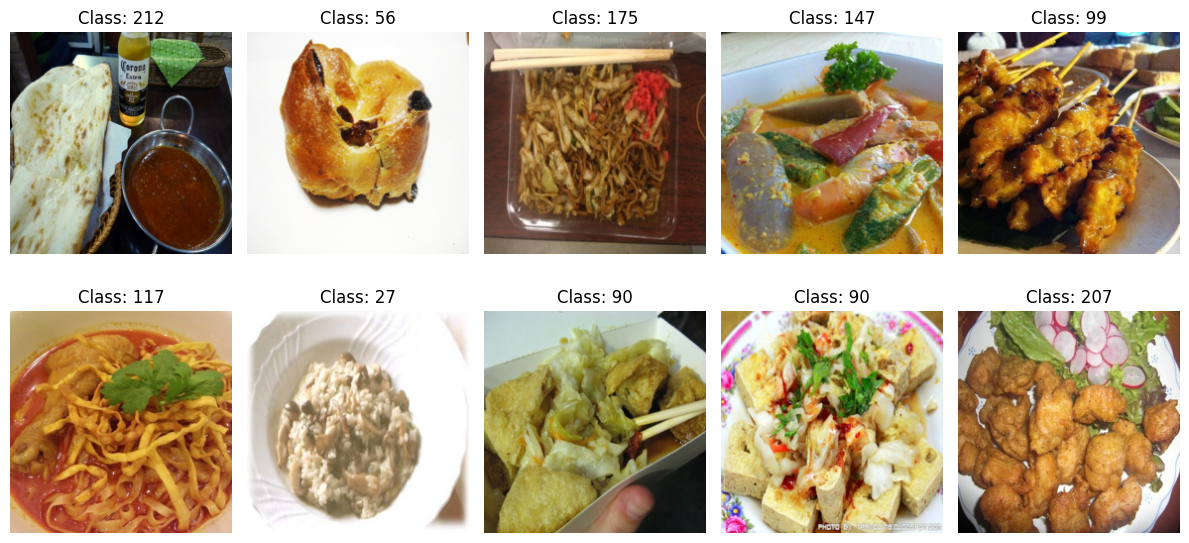

In [ ]:
import matplotlib.pyplot as plt
import random

# Randomly select some pictures
num_images = 10  # Number of images to display
indices = random.sample(range(len(dataset)), num_images)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    image, label = dataset[idx]
    image = image.permute(1, 2, 0)
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f"Class: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Here are some examples of dishes

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 256)
model.load_state_dict(torch.load('food_recognition_model_resnet50_v3.pth', map_location=device))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
category_file = "category.txt"
df = pd.read_csv(category_file, sep="\t", header=0)
id_to_label = dict(zip(df["id"], df["name"]))

id_to_label = {int(k): v for k, v in id_to_label.items()}

print(f"{len(id_to_label)} class")

256 class


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def process_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image.to(device)


In [ ]:
import torch

def predict_food(image_path):
    image_tensor = process_image(image_path)

    with torch.no_grad():
        outputs = model(image_tensor)
        predicted_class = torch.max(outputs, 1)[1].item()

    with open("class_to_idx.json", "r") as f:
        class_to_idx_real = json.load(f)

    idx_to_class = {v: int(k) for k, v in class_to_idx_real.items()}
    real_class_id = idx_to_class.get(predicted_class, "Unknown")


    category_name = id_to_label.get(real_class_id, "Unknown")

    print(f"image {image_path} class: {category_name}")
    print(f"class_id: {real_class_id}")

image_path = "1700.jpg"
predict_food(image_path)


image 1700.jpg class: pizza
class_id: 18


Use some images from the test set to test whether the output meets expectations. Test multiple images and the accuracy is very high.

## Model 3 : AI-Enhanced Recipe Generator

This part focuses on enhancing recipe understanding by extracting and enriching recipe data using both structured datasets and AI-based inference via DeepSeek API.

Given a user-provided dish name, the system matches the closest known recipe from a dataset, extracts ingredients and steps, and enriches it with difficulty estimation, allergen warnings, and dietary labels.


In [ ]:
import kagglehub
import pandas as pd
import requests
import os
import ast
from difflib import get_close_matches
import re

### Data Loading & Preprocessing
The recipe data used in this part was obtained from a structured dataset containing over 500,000 recipes and 1,400,000 reviews. Each entry includes attributes such as dish name, ingredients, instructions, and nutritional information.

In [ ]:
# Download the dataset from KaggleHub
path = kagglehub.dataset_download("irkaal/foodcom-recipes-and-reviews")

print("Path to dataset files:", path)

100%|██████████| 723M/723M [00:09<00:00, 76.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/irkaal/foodcom-recipes-and-reviews/versions/2


In [ ]:
# Step 1: Load the recipes.csv dataset
recipes_df = pd.read_csv(os.path.join(path, "recipes.csv"))
# Step 2: Set your DeepSeek API Key
API_KEY = "sk-9618264c69e7485e9fe1d9ba92102614"

<Axes: title={'center': 'Top 10 Recipe Categories'}, xlabel='RecipeCategory'>

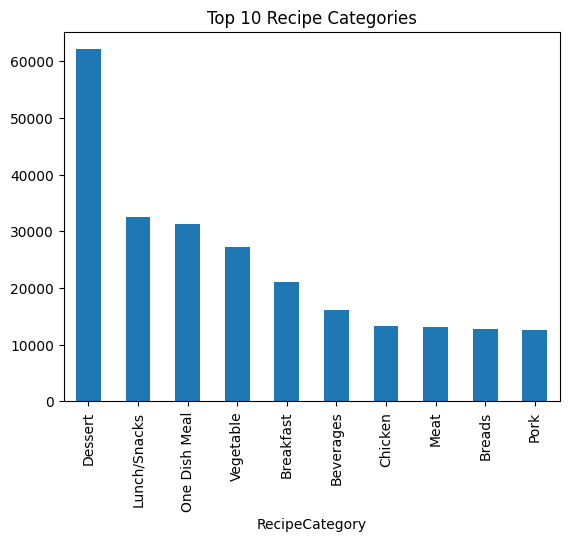

In [ ]:
# Dataset Visualization
recipes_df['RecipeCategory'].value_counts().head(10).plot(kind='bar', title='Top 10 Recipe Categories')

To prepare the data, we applied a combination of string normalization, list parsing, and missing-value handling. Recipe names were lowercased and matched using fuzzy string matching to identify the most relevant match for any given input.   
Ingredients and instructions were parsed from R-style or Python-style list strings using regular expressions and `ast.literal_eval`, while nutrition fields were preserved as-is for use in downstream prompts. A number of helper functions were implemented to clean instruction text, convert time fields from ISO 8601 to minutes, and validate input formats.

In [ ]:
def find_best_match(dish_name, recipe_names):
    """
    Finds the closest matching recipe name from the dataset using string similarity.

    Parameters:
        dish_name (str): The user-provided dish name.
        recipe_names (List[str]): A list of all recipe names in the dataset.

    Returns:
        str or None: The closest matching name if found, otherwise None.
    """
    matches = get_close_matches(dish_name.lower(), recipe_names, n=1, cutoff=0.6)
    return matches[0] if matches else None

def parse_list_column(column):
    """
    Parses a column that may contain a list-like string.

    Handles both R-style c("a", "b") lists and Python-style lists.

    Parameters:
        column: A column entry possibly representing a list.

    Returns:
        list: A list of string items parsed from the input.
    """
    try:
        if isinstance(column, str):
            if column.strip().startswith("c("):  # R-style list with quotes
                # Normalize: remove line breaks and extra whitespace
                cleaned = column.replace("\n", " ").strip()
                # Use regex to extract quoted strings
                return re.findall(r'"(.*?)"', cleaned)
            else:
                return ast.literal_eval(column)
        return []
    except Exception as e:
        print(f"[parse_list_column ERROR]: {e}")
        return []

def clean_output(text, format="plain"):
    """
    Cleans and formats the output text received from the API.

    Parameters:
        text: Raw text from the model output.
        format: Output format ('plain' or 'markdown').

    Returns:
        str: Cleaned text.
    """
    text = text.strip()
    if format == "plain":
        text = text.replace("**", "")
        text = text.replace("*", "")
        text = text.replace("\\n", "\n")
        text = text.replace("\n\n", "\n")
    return text


def parse_iso_time(iso_str):
    """
    Parses an ISO 8601 duration string into minutes.

    Parameters:
        iso_str: The ISO 8601 duration string.

    Returns:
        str: Total time in minutes, or 'Not specified' if parsing fails.
    """
    try:
        if not isinstance(iso_str, str):
            return "Not specified"
        match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?', iso_str)
        if not match:
            return "Not specified"
        hours = int(match.group(1)) if match.group(1) else 0
        minutes = int(match.group(2)) if match.group(2) else 0
        total_minutes = hours * 60 + minutes
        return f"{total_minutes} minutes" if total_minutes else "Not specified"
    except:
        return "Not specified"

def clean_step_text(step):
    """
    Cleans and standardizes a cooking step string by removing leading numbers.

    Parameters:
        step (str): The raw step string (e.g., "1. Mix the flour").

    Returns:
        str: Cleaned step (e.g., "Mix the flour").
    """
    return re.sub(r'^\s*\d+[\.\)]\s*', '', step).strip()

### Model Architecture
Once a dish name is matched to a known recipe, the corresponding ingredients, steps, and nutrition information are extracted. This information is then packaged into a structured prompt and sent to DeepSeek's language model via API. Two separate API calls are made: the first one queries the model to estimate the difficulty level of the recipe, while the second prompts it to identify potential allergen warnings and assign dietary labels such as "vegan", "halal", or "gluten-free". If no matching recipe exists or if essential data is missing such as ingredients or steps, the system switches to a fallback mode, where the entire recipe is generated by the language model from scratch based on the dish name alone. All results are returned in Markdown format for easy rendering and readability.

In [ ]:
def generate_recipe(dish_names, format="markdown"):
    url = "https://api.deepseek.com/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json"
    }

    # Normalize input to a list
    if isinstance(dish_names, str):
        dish_names = [dish_names]
        single_input = True
    else:
        single_input = False

    results = {}

    for dish_name in dish_names:
        # Match user input to closest recipe in dataset
        all_names = recipes_df['Name'].dropna().str.lower().tolist()
        matched_name = find_best_match(dish_name, all_names)

        if matched_name:

            # Retrieve matched recipe details
            matched_recipe = recipes_df[recipes_df['Name'].str.lower() == matched_name].iloc[0]
            ingredients = parse_list_column(matched_recipe['RecipeIngredientParts'])
            steps = parse_list_column(matched_recipe['RecipeInstructions'])

            # If ingredients or steps are missing, skip this match
            if len(ingredients) == 0 or len(steps) == 0:
                matched_name = None
            else:
                ingredients_text = "\n".join(f"- {i}" for i in ingredients)
                steps_text = "\n".join(f"{i+1}. {clean_step_text(s)}" for i, s in enumerate(steps))

                nutrition_text = (
                    f"- Calories: {matched_recipe['Calories']} kcal\n"
                    f"- Fat: {matched_recipe['FatContent']} g\n"
                    f"- Protein: {matched_recipe['ProteinContent']} g\n"
                    f"- Carbs: {matched_recipe['CarbohydrateContent']} g\n"
                    f"- Sugar: {matched_recipe['SugarContent']} g\n"
                    f"- Sodium: {matched_recipe['SodiumContent']} mg"
                )

                # Parse times from ISO strings
                prep_time = parse_iso_time(matched_recipe.get('PrepTime', ''))
                cook_time = parse_iso_time(matched_recipe.get('CookTime', ''))
                total_time = parse_iso_time(matched_recipe.get("TotalTime", ""))

                # Ask AI for Difficulty
                difficulty_prompt = f"""
Given the recipe name, ingredients, and cooking steps below, estimate the difficulty as one of: Easy, Medium, Hard. Just respond with one word.

Dish Name: {matched_recipe['Name']}

Ingredients:
{ingredients_text}

Cooking Steps:
{steps_text}
"""
                payload_diff = {
                    "model": "deepseek-chat",
                    "messages": [{"role": "user", "content": difficulty_prompt}],
                    "temperature": 0.5
                }
                diff_resp = requests.post(url, headers=headers, json=payload_diff)
                if diff_resp.status_code == 200:
                    difficulty = diff_resp.json()["choices"][0]["message"]["content"].strip().split()[0]
                else:
                    difficulty = "Not specified"

                # Ask AI for Allergen + Dietary Labels
                prompt_for_extra = f"""
Given the following recipe, generate ONLY:

### 5. Allergen Warnings
### 6. Dietary Labels (e.g. Vegan, Gluten-Free, Halal)

Dish Name: {matched_recipe['Name']}

Ingredients:
{ingredients_text}

Nutrition Facts (Per Serving):
{nutrition_text}

Cooking Steps:
{steps_text}
"""
                payload_extra = {
                    "model": "deepseek-chat",
                    "messages": [{"role": "user", "content": prompt_for_extra}],
                    "temperature": 0.7
                }
                response = requests.post(url, headers=headers, json=payload_extra)
                if response.status_code == 200:
                    extra_info = response.json()["choices"][0]["message"]["content"].strip()
                else:
                    extra_info = "### 5. Allergen Warnings\nNot specified\n\n### 6. Dietary Labels\nNot specified"

                # Combine everything into final markdown output
                full_text = f"""
**Source:** Dataset

## Dish Name: {matched_recipe['Name']}

### 1. Time & Difficulty
- Prep Time: {prep_time}
- Cook Time: {cook_time}
- Total Time: {total_time}
- Difficulty: {difficulty}

### 2. Nutrition Facts (Per Serving)
{nutrition_text}

### 3. Ingredients
{ingredients_text}

### 4. Cooking Steps
{steps_text}

{extra_info}
"""
                results[dish_name] = clean_output(full_text, format=format)
                continue

        # If no match or incomplete data, fallback to AI to generate recipe
        fallback_prompt = f"""
This recipe is AI-generated.

Please generate a clean, markdown-formatted recipe for:

Dish Name: {dish_name}

Your output must follow this structured markdown format:

## Dish Name: <name>

### 1. Time & Difficulty
- Prep Time:
- Cook Time:
- Total Time:
- Difficulty: Easy / Medium / Hard

### 2. Nutrition Facts (Per Serving)
- Calories:
- Protein (g):
- Carbohydrates (g):
- Fat (g):

### 3. Ingredients
- item 1
- item 2
...

### 4. Cooking Steps
1. Step one
2. Step two
...

### 5. Allergen Warnings
...

### 6. Dietary Labels
...

Important:
- Do not skip section 4. Cooking Steps
- Do not include notes or suggestions
- Start directly with “## Dish Name:”
"""

        for _ in range(2): # Try up to 2 times
            payload = {
                "model": "deepseek-chat",
                "messages": [{"role": "user", "content": fallback_prompt}],
                "temperature": 0.7
            }
            response = requests.post(url, headers=headers, json=payload)
            if response.status_code == 200:
                raw_text = response.json()["choices"][0]["message"]["content"]
                if "### 4. Cooking Steps" in raw_text or "4. Cooking Steps" in raw_text:
                    raw_text = "**Source:** AI Generated\n\n" + raw_text
                    break
            else:
                raw_text = f"Error: {response.status_code}, {response.text}"
                break

        # Store fallback result
        results[dish_name] = clean_output(raw_text, format=format)

    return results[dish_names[0]] if single_input else results

### Results

In [ ]:
# From dataset: Dish Name, Prep Time, Cook Time, Total Time, Nutrition Facts, Ingredients, Cooking Steps
# AI-generated: Difficulty, Allergen Warnings, Dietary Labels

from IPython.display import Markdown
Markdown(generate_recipe("Hot Dog", format="markdown"))

**Source:** Dataset

## Dish Name: Hotdogs

### 1. Time & Difficulty  
- Prep Time: 10 minutes  
- Cook Time: 13 minutes  
- Total Time: 23 minutes  
- Difficulty: Medium

### 2. Nutrition Facts (Per Serving)  
- Calories: 318.5 kcal
- Fat: 18.9 g
- Protein: 10.6 g
- Carbs: 26.1 g
- Sugar: 6.0 g
- Sodium: 788.0 mg

### 3. Ingredients  
- tomatoes
- mustard
- mayonnaise
- ketchup
- bacon
- butter

### 4. Cooking Steps  
1. Dice and set aside all the veggies.
2. Wrap the wienies with the bacon covering end to end.
3. Heat your skillet.
4. When all of your wienies have been wrapped place them in the skillet and cook the bacon until crisp all around careful not to burn the wienie.
5. After you have crisped the bacon make an incision from end to end careful not to cut all the way thru.
6. Open the wienie and cook cut side down till slightly browned.
7. Set the cooked wienies aside and toast the hotdog buns either in the bacon grease mmm or use another skillet and add a little butter and toast either way it is delicious.
8. When the buns are ready add the bacon wrapped wienies to the buns cut side up.
9. Add the mayo, mustard, and ketchup in that order in the center of the wienie.
10. Then add the onion, tomato, and jalapenos in that order.
11. NOW Enjoy !

### 5. Allergen Warnings  
- Contains eggs (mayonnaise)  
- Contains dairy (butter)  
- Contains wheat (hotdog buns)  
- May contain soy (processed ingredients like bacon, hotdogs, or condiments)  

### 6. Dietary Labels  
- Not vegetarian (contains bacon and hotdogs)  
- Not vegan (contains bacon, butter, and mayonnaise)  
- Not gluten-free (hotdog buns typically contain wheat)  
- Not halal (contains bacon unless substituted with halal-certified meat)  
- Not kosher (bacon is non-kosher)

In [ ]:
# Muti-dishes
results = generate_recipe(["Buttermilk Pie", "Spaghetti Carbonara"], format="markdown")

for name, content in results.items():
    display(Markdown(f"## {name}\n\n{content}"))

## Buttermilk Pie

**Source:** Dataset

## Dish Name: Buttermilk Pie

### 1. Time & Difficulty  
- Prep Time: 20 minutes  
- Cook Time: 60 minutes  
- Total Time: 80 minutes  
- Difficulty: Medium

### 2. Nutrition Facts (Per Serving)  
- Calories: 395.9 kcal
- Fat: 19.1 g
- Protein: 5.0 g
- Carbs: 52.2 g
- Sugar: 39.9 g
- Sodium: 269.8 mg

### 3. Ingredients  
- butter
- margarine
- sugar
- flour
- eggs
- salt
- vanilla
- buttermilk

### 4. Cooking Steps  
1. Preheat oven to 400°F.
2. Beat the butter and sugar together until light.
3. Add the eggs and beat; then beat in vanilla.
4. Sift the dry ingredients together and add to the batter alternatively with the buttermilk; beat until smooth.
5. Pour into a deep dish pie shell and bake at 400F for 10 minutes, reduce heat to 350F and bake for 50-60 additional minutes.
6. Pie should turn a nice golden brown and a knife inserted should come out clean.
7. I think it is absolutely best when it is just still warm. (Not too hot, or it will be like napalm.).

### 5. Allergen Warnings  
- **Dairy**: Contains butter, margarine, and buttermilk.  
- **Eggs**: Contains eggs.  
- **Gluten**: Contains flour (unless specified as gluten-free).  

### 6. Dietary Labels  
- **Vegetarian**: Contains no meat or fish.  
- **Not Vegan**: Contains dairy and eggs.  
- **Not Gluten-Free**: Contains wheat flour.  
- **Not Halal**: Contains vanilla (if alcohol-based) unless specified otherwise.  
- **High Sugar**: Contains significant added sugar.

## Spaghetti Carbonara

**Source:** Dataset

## Dish Name: Spaghetti Carbonara

### 1. Time & Difficulty  
- Prep Time: 20 minutes  
- Cook Time: 20 minutes  
- Total Time: 40 minutes  
- Difficulty: Medium

### 2. Nutrition Facts (Per Serving)  
- Calories: 546.9 kcal
- Fat: 5.4 g
- Protein: 20.3 g
- Carbs: 92.0 g
- Sugar: 5.5 g
- Sodium: 67.5 mg

### 3. Ingredients  
- prosciutto
- bacon
- onion
- shallot
- garlic clove
- olive oil
- spaghetti
- eggs
- mixed cheese
- parsley
- dry white wine

### 4. Cooking Steps  
1. Set a large pot of water to boil with about 1 Tbs olive oil and a few good shakes of salt for the pasta.
2. Add about a Tbs of olive oil to a large frying pan and heat over Med heat.
3. Add garlic and sauté until just barely brown.
4. Add onions and shallots, sauté until they are translucent.
5. Add meat and cook until meat is not quite cooked.
6. Add white wine and simmer on low heat.
7. Mix eggs parsley and half of the cheese mixture, set aside.
8. When pasta is done until just BEFORE al dente; strain it and add to frying pan with the meat mixture.
9. Toss well while adding the egg+cheese+parsley mixture gradually.
10. Put pasta in a preheated serving bowl and sprinkle some more cheese on top along with some fresh ground black pepper.
11. Serve immediately.

### 5. Allergen Warnings  
- **Eggs**  
- **Dairy** (mixed cheese)  
- **Wheat** (spaghetti)  

### 6. Dietary Labels  
- **Contains Meat** (prosciutto, bacon)  
- **Not Vegetarian/Vegan**  
- **Not Gluten-Free** (spaghetti)  
- **Not Halal** (unless using halal-certified meat)  
- **Not Dairy-Free** (cheese)

To evaluate the pipeline, several sample dishes were processed through the system. For example, when given the input “Hot Dog,” the system matched it to an existing dataset entry titled “Hotdogs.” The output included an estimated preparation time of 10 minutes, a cook time of 13 minutes, and a total time of 23 minutes. The model classified the difficulty level as “Medium” and correctly identified allergens such as eggs (from mayonnaise), dairy (from butter), and wheat (from the hotdog buns). Additionally, it flagged the recipe as non-vegan, non-halal, and not gluten-free. The generated content also included complete ingredient lists and step-by-step cooking instructions, demonstrating the system’s ability to present information in a coherent and structured manner.

Further testing on multiple dish inputs—such as “Buttermilk Pie” and “Spaghetti Carbonara”—showed consistent performance. The recipes were either retrieved from the dataset or generated directly from the model, with both types including enriched metadata such as estimated difficulty and dietary filters. In all cases, the final Markdown output adhered to a uniform format, making it suitable for both display and programmatic consumption.


### Comparison with Direct Prompting in DeepSeek

To evaluate the added value of our structured pipeline, we conducted a direct query to DeepSeek using a free-form prompt: *"Give me a recipe for a classic American hot dog."* The model responded with a detailed, human-friendly description, including ingredients, multiple preparation methods, assembly tips, and suggested toppings.




In [ ]:
api_url = "https://api.deepseek.com/v1/chat/completions"
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}
prompt = "Give me a full recipe for Hot Dog"
payload = {
    "model": "deepseek-chat",
    "messages": [{"role": "user", "content": prompt}],
    "temperature": 0.7
}
response = requests.post(api_url, headers=headers, json=payload)
print(response.json()["choices"][0]["message"]["content"])


Certainly! Here’s a **classic American hot dog recipe** with all the fixings.  

### **Classic Hot Dog Recipe**  
**Servings:** 4  
**Prep Time:** 5 minutes  
**Cook Time:** 10 minutes  

#### **Ingredients:**  
- **4 hot dog buns** (preferably soft, split-top)  
- **4 beef or pork hot dogs** (e.g., Nathan’s, Hebrew National, or your favorite brand)  
- **1 tbsp butter** (optional, for toasting buns)  
- **Condiments of choice:**  
  - Yellow mustard  
  - Ketchup  
  - Relish (sweet or dill)  
  - Chopped onions (white or red)  
  - Sauerkraut (for a Chicago-style twist)  
  - Pickle spears  
  - Jalapeños (sliced, for heat)  
  - Shredded cheddar cheese (optional)  

#### **Instructions:**  

1. **Prepare the Hot Dogs:**  
   - **Grill Method (Recommended):**  
     - Preheat grill to medium heat.  
     - Grill hot dogs for 5-7 minutes, turning occasionally, until lightly charred and heated through.  
   - **Stovetop Method:**  
     - Bring a pot of water to a simmer (not boiling) 

While the response was informative and enjoyable to read, it lacked the formal structure required for consistent storage, parsing, or display. For example, there was no explicit nutritional breakdown, difficulty rating, or allergen labeling. The time-related fields were embedded in text and not easily extractable. Furthermore, the formatting may vary across prompts, making it challenging to automate or reuse the results programmatically.

In contrast, our system produced the same recipe with standardized formatting, organized sections, and AI-generated fields such as estimated difficulty level, allergen warnings, and dietary labels. This structure ensures reproducibility and supports diverse use cases such as dietary filtering, API integration, or web rendering. The comparison highlights how our approach offers more control and reliability while still leveraging DeepSeek's generative capabilities.


| Feature                 | Our System Output               | DeepSeek Direct Output           |
|------------------------|----------------------------------|----------------------------------|
| Structured Format       |  Yes (Markdown Template)       |  No (Free-form Text)           |
| Includes Nutrition Info |  Yes (from dataset)            |  No                            |
| Includes Difficulty     |  Yes (AI-estimated)            | No                            |
| Allergen Warnings       |  Yes (AI-generated)            | No                            |
| Format Consistency      | High                         |  Varies Across Prompts        |
| Expandable for UI/API   |  Easy to use in apps/websites |  Needs post-processing         |


## Combination

Combine model_1 and model_2:

In [ ]:
def combine_models(model_1, model_2, image):
    # Get YOLO detections
    yolo_result = get_yolo_result(model_1, image,output_dir="crop_output")

    # Prepare ResNet-50
    model_2.eval()
    model_2.to(device)

    # Store results
    cls_preds = []
    cls_confs = []

    # Process each crop like validation data
    for crop in yolo_result['food_images']:
        if crop.size == 0:
            continue  # Skip invalid detections

        # Convert to PIL RGB (matching ImageFolder's loading)
        crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        crop_pil = Image.fromarray(crop_rgb)

        # Apply validation transforms
        tensor = val_transform(crop_pil).unsqueeze(0).to(device)

        # Classify
        with torch.no_grad():
            outputs = model_2(tensor)

        # Get probabilities
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, 1)

        cls_preds.append(pred.item())
        cls_confs.append(conf.item())

    return  cls_preds, cls_confs

def get_category(category_file_path, class_to_idx_path):
    final_projection = {}
    with open(class_to_idx_path, 'r') as file:
        mod_dict = json.load(file)
    mod_dict = {value: key for key, value in mod_dict.items()}
    data_dict = {}
    with open(category_file_path, 'r', encoding='utf-8') as file:
        # Skip the header line
        next(file)
        for line in file:
            # Strip newline and split by tab
            parts = line.strip().split('\t')
            if len(parts) == 2:
                key, value = parts
                data_dict[key] = value
    for idx in mod_dict:
        final_projection[idx] = data_dict[str(mod_dict[idx])]
    return final_projection

A sample demonstrating the complete process:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MODEL 1
model_1 = YOLO("best_model1.pt")

# MODEL 2
model_2 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model_2.fc.in_features
model_2.fc = nn.Linear(num_ftrs, 256)
model_2.load_state_dict(torch.load('food_recognition_model_resnet50_v3.pth',
                                   map_location=device))
category_dict = get_category('category.txt', "class_to_idx.json")

# MODEL 3
path = kagglehub.dataset_download("irkaal/foodcom-recipes-and-reviews")
recipes_df = pd.read_csv(os.path.join(path, "recipes.csv"))
API_KEY = "sk-9618264c69e7485e9fe1d9ba92102614"

# PROCESSING
input_dir = "98_15345.jpg"

image = cv2.imread(input_dir)

predictions_idx, _ = combine_models(model_1, model_2, image)
predictions_food = []

for i in predictions_idx:
    predictions_food.append(category_dict[i])
print(predictions_food)

with open('recipes_output.md', 'w') as file:
    for i in predictions_food:
        markdown_text = generate_recipe(i, format="markdown")
        file.write(markdown_text + '\n\n')

## Discussion

In this project, we designed and implemented a system that can automatically generate recipes from food images. The system consists of three main modules: YOLOv11 for object detection, ResNet50 for food classification, and DeepSeek API for recipe generation. Overall, we believe the model performed well and met our expectations across different stages of the pipeline.

First, for the object detection part, YOLOv11 achieved a mAP of 94.1% and a recall rate of 98% on the test set. This shows that it is highly robust in detecting various food items. Especially in multi-food images, YOLOv11 was able to accurately segment each dish, even when the food items were overlapping, stacked together, or appeared with complex backgrounds. This is an important feature for real-world applications.

Next, for classification, we used a pre-trained ResNet50 model, which reached an accuracy of 86.08%. Although this is slightly lower than detection performance, it is still quite practical given the imbalance in data and the high visual similarity between certain dishes. In some images, even when the classification model predicted the same label for similar-looking items, YOLO's precise segmentation allowed the recipe generation process to still work well.

For the language model, we used the DeepSeek API to generate recipes. The output is not only well-structured and easy to read, but also includes detailed sections such as ingredients, nutrition facts, step-by-step instructions, allergen warnings, and dietary labels. It also handled multiple dishes in one image smoothly, generating a complete and separate recipe for each dish, which is very useful in real-life scenarios.

There were also some areas that could be improved. For example, the classification errors mainly occurred with dishes that looked very similar. In the future, we could try incorporating attention mechanisms or ensemble models to improve classification accuracy. Also, since the language model relies completely on the classification output, any classification mistake directly affects the quality of the final recipe. This highlights how different parts of a multimodal system are closely connected.

Through this project, we not only deepened our understanding of object detection and image classification but also gained hands-on experience in connecting visual data to language generation. Most importantly, we learned about the challenges of building an end-to-end AI system and the importance of collaboration when designing pipelines, processing data, debugging models, and integrating components.

## Citation

1. Gupta, A., Arora, S., Jain, M., & Jain, K. (2023, March). Comparative Analysis of ResNet-18 and ResNet-50 Architectures for Pneumonia Detection in Medical Imaging. In Doctoral Symposium on Computational Intelligence (pp. 355–365). Singapore: Springer Nature Singapore.

2. Targ, S., Almeida, D., & Lyman, K. (2016). Resnet in resnet: Generalizing residual architectures. arXiv preprint arXiv:1603.08029.

3. Kawano, Y. and Yanai, K (2014). Automatic Expansion of a Food Image Dataset Leveraging Existing Categories with Domain Adaptation. Proc. of ECCV Workshop on Transferring and Adapting Source Knowledge in Computer Vision (TASK-CV)

4. Glenn Jocher, Jing Qiu. (2024). Ultralytics YOLO11 (Version 11.0.0) https://github.com/ultralytics/ultralytics.  
